<a href="https://colab.research.google.com/github/CanduriFranklin/OriumSpaceRX/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Challenge to develop a machine learning model to predict heat island hotspots in an urban location. Furthermore, the model should be designed to discern and highlight the key factors that significantly contribute to the development of these hotspots within urban environments.

# Design, develop, train and implement a "Random Forest" model.

# Structure for Organizing the Notebook
Organization of the notebook as follows:

1.- Loading and Processing Data.

2.- Model Training.

3.- Model Evaluation.

4.- Model Interpretation (SHAP).

5.- Model Saving.


Dependencies (Libraries)

In [1]:
pip install torch torchvision pandas numpy opencv-python scikit-learn matplotlib seaborn google-colab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

# 1.- Data Loading and Processing

In [3]:
!pip install openpyxl
import pandas as pd

def cargar_y_procesar_datos(file_path):
    """
    Carga y procesa los datos desde un archivo Excel.

    Parámetros:
        file_path (str): Ruta del archivo Excel en Google Colab.

    Retorna:
        df_model (DataFrame): DataFrame procesado con las características y el UHI.
    """
    # Cargar las hojas del archivo Excel
    df_bronx = pd.read_excel(file_path, sheet_name='Bronx')
    df_manhattan = pd.read_excel(file_path, sheet_name='Manhattan')

    # Mostrar las primeras filas de cada DataFrame para verificar
    print("Datos del Bronx:")
    print(df_bronx.head())

    print("\nDatos de Manhattan:")
    print(df_manhattan.head())

    # Convertir la columna de fecha y hora a tipo datetime
    df_bronx['Date / Time'] = pd.to_datetime(df_bronx['Date / Time'])
    df_manhattan['Date / Time'] = pd.to_datetime(df_manhattan['Date / Time'])

    # Combinar los datos de las estaciones meteorológicas
    df_combined = pd.merge(df_bronx, df_manhattan, on='Date / Time', how='left', suffixes=('_bronx', '_manhattan'))

    # Calcular el UHI como la diferencia de temperatura entre el Bronx y Manhattan
    df_combined['UHI'] = df_combined['Air Temp at Surface [degC]_bronx'] - df_combined['Air Temp at Surface [degC]_manhattan']

    # Calcular el Heat Index (índice de calor) para ambas estaciones
    def calculate_heat_index(temp, humidity):
        # Fórmula simplificada del Heat Index
        return temp + 0.5 * humidity

    df_combined['Heat_Index_bronx'] = calculate_heat_index(df_combined['Air Temp at Surface [degC]_bronx'], df_combined['Relative Humidity [percent]_bronx'])
    df_combined['Heat_Index_manhattan'] = calculate_heat_index(df_combined['Air Temp at Surface [degC]_manhattan'], df_combined['Relative Humidity [percent]_manhattan'])

    # Seleccionar las columnas relevantes para el modelo
    features = [
        'Air Temp at Surface [degC]_bronx',  # Temperatura del Bronx
        'Relative Humidity [percent]_bronx',  # Humedad del Bronx
        'Avg Wind Speed [m/s]_bronx',  # Velocidad del viento del Bronx
        'Wind Direction [degrees]_bronx',  # Dirección del viento del Bronx
        'Solar Flux [W/m^2]_bronx',  # Flujo solar del Bronx
        'Air Temp at Surface [degC]_manhattan',  # Temperatura de Manhattan
        'Relative Humidity [percent]_manhattan',  # Humedad de Manhattan
        'Avg Wind Speed [m/s]_manhattan',  # Velocidad del viento de Manhattan
        'Wind Direction [degrees]_manhattan',  # Dirección del viento de Manhattan
        'Solar Flux [W/m^2]_manhattan',  # Flujo solar de Manhattan
        'Heat_Index_bronx',  # Heat Index del Bronx
        'Heat_Index_manhattan'  # Heat Index de Manhattan
    ]

    # Crear un DataFrame con las características y la variable objetivo (UHI)
    df_model = df_combined[features + ['UHI']]

    # Eliminar filas con valores faltantes (si las hay)
    df_model.dropna(inplace=True)

    return df_model

# Ruta del archivo en Google Colab
file_path = '/content/NY_Mesonet_Weather_New_Data.xlsx'

# Cargar y procesar los datos
df_model = cargar_y_procesar_datos(file_path)

# Mostrar el DataFrame final
print("\nDataFrame Final para el Modelo:")
print(df_model.head())

# Guardar el DataFrame procesado en un nuevo archivo Excel
output_file_path = '/content/NY_Mesonet_Weather_Processed.xlsx'
df_model.to_excel(output_file_path, index=False)

print(f"\nDatos procesados guardados en: {output_file_path}")

Datos del Bronx:
               Date / Time  Air Temp at Surface [degC]  \
0  2021-07-24 06:00:00 EDT                        19.3   
1  2021-07-24 06:05:00 EDT                        19.4   
2  2021-07-24 06:10:00 EDT                        19.3   
3  2021-07-24 06:15:00 EDT                        19.4   
4  2021-07-24 06:20:00 EDT                        19.4   

   Relative Humidity [percent]  Avg Wind Speed [m/s]  \
0                         88.2                   0.8   
1                         87.9                   0.8   
2                         87.6                   0.7   
3                         87.4                   0.5   
4                         87.0                   0.2   

   Wind Direction [degrees]  Solar Flux [W/m^2]  
0                       335                  12  
1                       329                  18  
2                       321                  25  
3                       307                  33  
4                       301                  42

<ipython-input-3-b813d5a71465>:26: FutureWarning: Parsed string "2021-07-24 06:00:00 EDT" included an un-recognized timezone "EDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df_bronx['Date / Time'] = pd.to_datetime(df_bronx['Date / Time'])
<ipython-input-3-b813d5a71465>:27: FutureWarning: Parsed string "2021-07-24 06:00:00 EDT" included an un-recognized timezone "EDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df_manhattan['Date / Time'] = pd.to_datetime(df_manhattan['Date / Time'])
<ipython-input-3-b813d5a71465>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

# 2. Model Training

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import unittest

# Cargar los datos procesados
df_model = pd.read_excel('/content/NY_Mesonet_Weather_Processed.xlsx')

# Separar características (X) y variable objetivo (y)
X = df_model.drop('UHI', axis=1)
y = df_model['UHI']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear y entrenar el modelo
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_test)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'R²: {r2}')

# Pruebas unitarias para verificar el funcionamiento del modelo
class TestModel(unittest.TestCase):
    def test_model_training(self):
        """Verifica que el modelo se entrene correctamente."""
        self.assertIsNotNone(model, "El modelo no se entrenó correctamente.")

    def test_model_predictions(self):
        """Verifica que el modelo haga predicciones."""
        predictions = model.predict(X_test)
        self.assertEqual(len(predictions), len(y_test), "El número de predicciones no coincide con el número de pruebas.")

    def test_model_performance(self):
        """Verifica que el rendimiento del modelo sea aceptable."""
        self.assertGreater(r2, 0.5, f"El R² es demasiado bajo: {r2}")
        self.assertLess(mse, 10, f"El MSE es demasiado alto: {mse}")

# Ejecutar las pruebas unitarias
if __name__ == '__main__':
    unittest.main(argv=[''], exit=False)

...
----------------------------------------------------------------------
Ran 3 tests in 0.022s

OK


MSE: 0.052841235294117654
R²: 0.9675291604871332


# 3. Model Interpretation (SHAP)

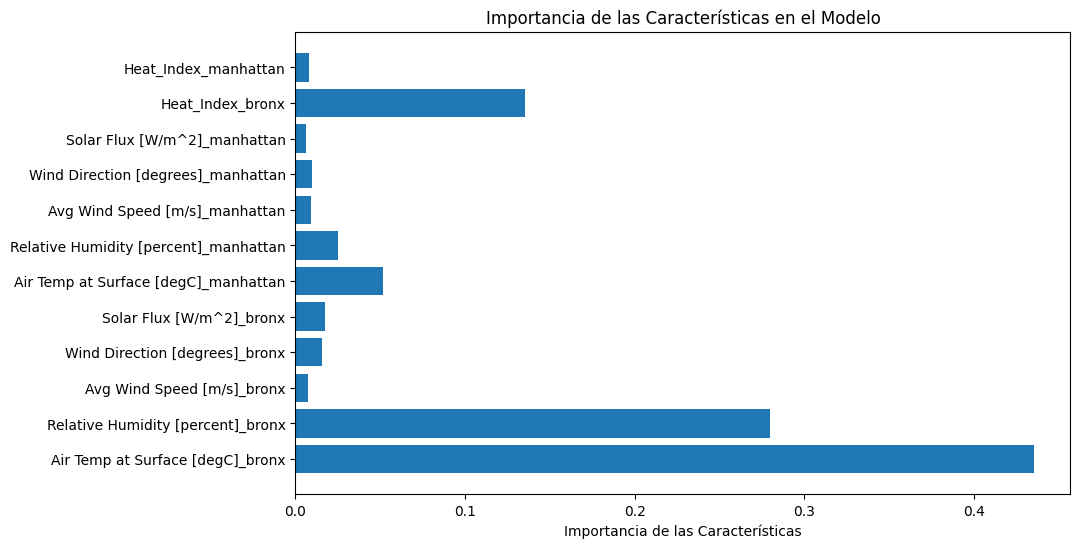

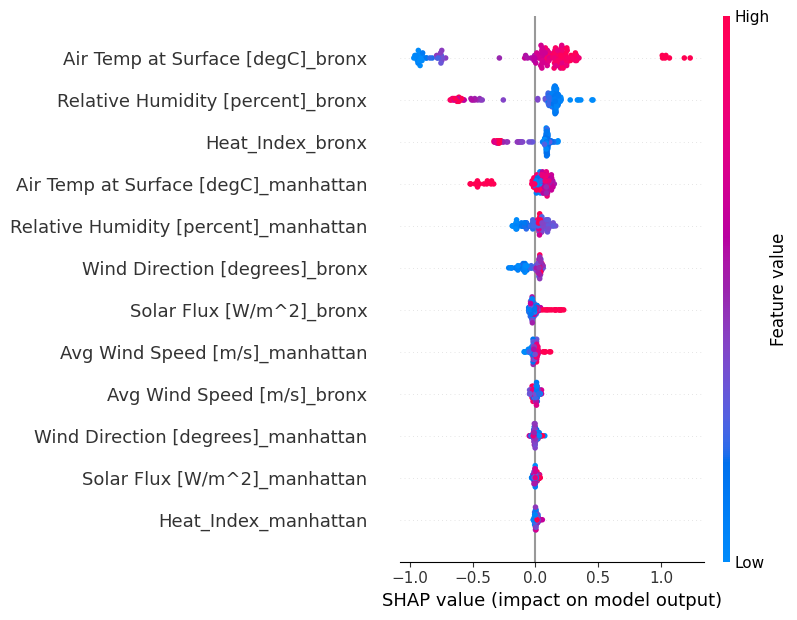

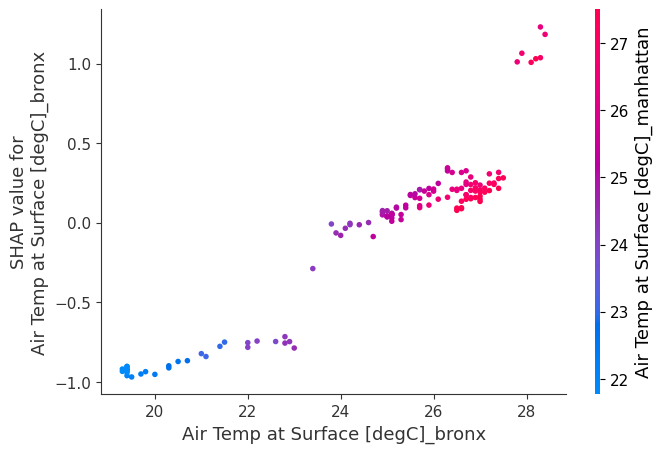

In [5]:
# Código para interpretar el modelo con SHAP
!pip install shap
import matplotlib.pyplot as plt
import numpy as np
import shap

# 1. Importancia de Características
importances = model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances, align='center')
plt.yticks(np.arange(len(importances)), feature_names)
plt.xlabel('Importancia de las Características')
plt.title('Importancia de las Características en el Modelo')
plt.show()

# 2. SHAP Values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# Graficar la importancia de las características
shap.summary_plot(shap_values, X_train)

# 3. Dependencia Parcial (ejemplo con una característica)
shap.dependence_plot('Air Temp at Surface [degC]_bronx', shap_values, X_train)

# 4. Saving the Model

In [6]:
# Código para guardar el modelo
import joblib

# Guardar el modelo
joblib.dump(model, 'oriumx_uhi_prediction_model.pkl')

print("Modelo guardado como 'oriumx_uhi_prediction_model.pkl'.")

# Cargar el modelo (opcional, para verificar)
model = joblib.load('oriumx_uhi_prediction_model.pkl')

Modelo guardado como 'oriumx_uhi_prediction_model.pkl'.


# Save Intermediate Results:

In [ ]:
plt.savefig('importancia_caracteristicas.png')

<Figure size 640x480 with 0 Axes>